# Introduction to Data Science
## Clustering
***

Read in some packages.

In [96]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from pylab import cm

%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 14, 8

np.random.seed(36)

# We will want to keep track of some different roc curves, lets do that here
tprs = []
fprs = []
roc_labels = []

# ###################################################
# Similarity, Distance, Nearest Neighbors, Clustering
# ###################################################

### Data
We have a data set describing many characteristics of scotch. You can find it in `data/scotch.csv`.

The data consists of 5 general whiskey attributes, each of which has many possible values:

- **Color**: yellow, very pale, pale, pale gold, gold, old gold, full gold, amber, etc.
- **Nose**: aromatic, peaty, sweet, light, fresh, dry, grassy, etc.
- **Body**: soft, medium, full, round, smooth, light, firm, oily.
- **Palate**: full, dry, sherry, big, fruity, grassy, smoky, salty, etc.
- **Finish**: full, dry, warm, light, smooth, clean, fruity, grassy, smoky, etc.

Let's read it in and take a look.

In [2]:
data = pd.read_csv("data/scotch.csv")
data = data.drop([u'age', u'dist', u'score', u'percent', u'region', u'district', u'islay', u'midland', u'spey', u'east', u'west', u'north ', u'lowland', u'campbell', u'islands'], axis=1)

In [3]:
data.head()

,color.wyne,color.yellow,color.v.pale,color.pale,color.p.gold,color.gold,color.o.gold,color.f.gold,color.bronze,color.p.amber,...,fin.smoke,fin.sweet,fin.spice,fin.oil,fin.salt,fin.arome,fin.ling,fin.long,fin.very,fin.quick
Aberfeldy,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Aberlour,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Ardberg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Ardmore,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Auchentoshan,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Similarity measures
Each of our whiskeys can be described by its feature vector (68 attributes). Consider Foster's favorite, "Bunnahabhain".

In [ ]:
data.loc['Bunnahabhain']

What other entries do we have that are similar?

In [4]:
def whiskey_distance(name, distance_measures, n):
    # We want a data frame to store the output
    distances = pd.DataFrame()
    # Find the location of the whiskey we are looking for
    whiskey_location = np.where(data.index == name)[0][0]
    # Go through all distance measures we care about
    for distance_measure in distance_measures:
        # Find all pairwise distances
        current_distances = distance.squareform(distance.pdist(data, distance_measure))
        # Get the closest n for the whiskey we care about
        most_similar = np.argsort(current_distances[:, whiskey_location])[0:n]
        # Append results
        distances[distance_measure] = zip(data.index[most_similar], current_distances[most_similar, whiskey_location])
    return distances

In [5]:
whiskey_distance('Bunnahabhain', ['euclidean'], 5)

,euclidean
0,"(Bunnahabhain, 0.0)"
1,"(Glenglassaugh, 3.0)"
2,"(Ardberg, 3.16227766017)"
3,"(Bruichladdich, 3.16227766017)"
4,"(Tullibardine, 3.31662479036)"


In [6]:
whiskey_distance('Bunnahabhain', ['euclidean', 'cityblock', 'cosine'], 5)

,euclidean,cityblock,cosine
0,"(Bunnahabhain, 0.0)","(Bunnahabhain, 0.0)","(Bunnahabhain, 0.0)"
1,"(Glenglassaugh, 3.0)","(Glenglassaugh, 9.0)","(Glenglassaugh, 0.472953723305)"
2,"(Ardberg, 3.16227766017)","(Ardberg, 10.0)","(Tullibardine, 0.473765188416)"
3,"(Bruichladdich, 3.16227766017)","(Bruichladdich, 10.0)","(Glenmorangie, 0.492907447163)"
4,"(Tullibardine, 3.31662479036)","(Tullibardine, 11.0)","(Bruichladdich, 0.5)"


### Clustering
Can we find groups of whiskeys that are simliar?

#### Hierarchical

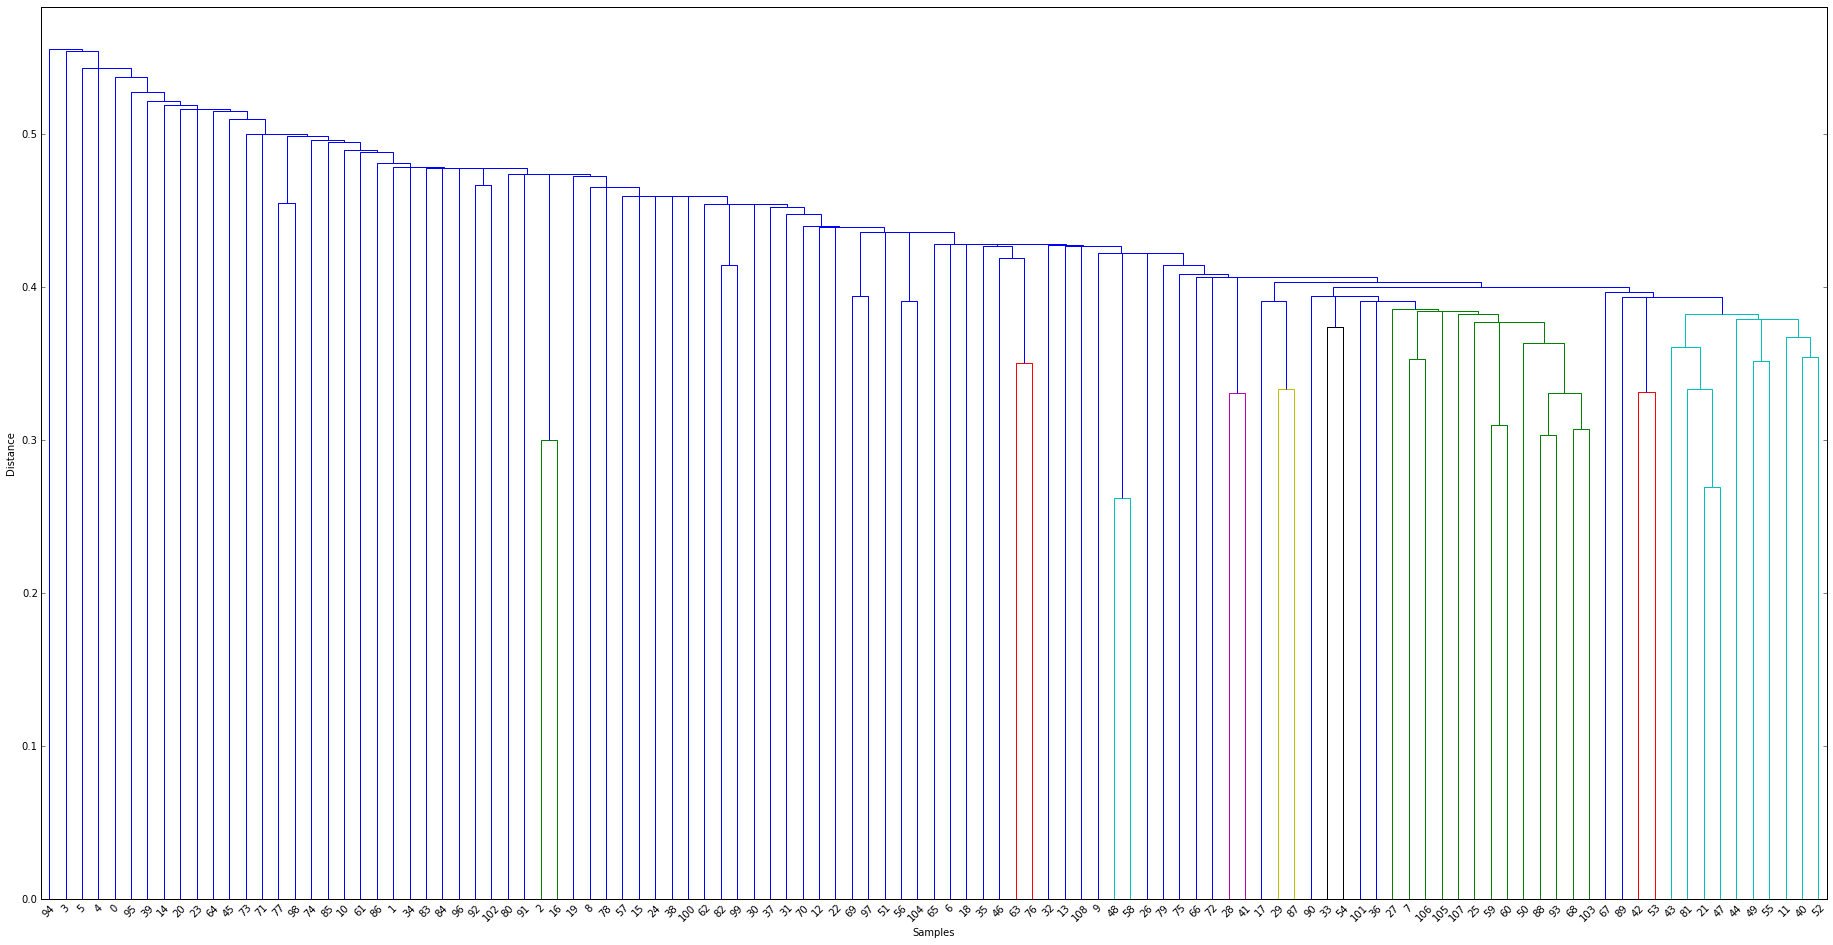

In [18]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn import cluster

# This function gets pairwise distances between observations in n-dimensional space.
dists = pdist(data, metric="cosine")

# This function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
links = linkage(dists)

p = 46
# Now we want to plot the dendrogram
plt.rcParams['figure.figsize'] = 32, 16
den = dendrogram(links, p = p)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(rotation=45)
plt.show()
plt.rcParams['figure.figsize'] = 10, 8
# plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);

#### KMeans

In [32]:
k_clusters = 6

# Fit and predict clusters
model = KMeans(k_clusters)
model.fit(data)
clusters = model.predict(data)

# Do some messy stuff to print a nice table of clusters
# This is a terrible way of doing anything, please don't emulate this :D
cluster_listing = {}
for cluster in range(k_clusters):
    cluster_listing['Cluster ' + str(cluster)] = [''] * 109
    where_in_cluster = np.where(clusters == cluster)[0]
    cluster_listing['Cluster ' + str(cluster)][0:len(where_in_cluster)] = data.index[where_in_cluster]

# Print clusters
pd.DataFrame(cluster_listing)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,Aberfeldy,Banff,Aberlour,Ardmore,Blair Athol,Ardberg
1,Aultmore,Benromach,Balmenach,Auchentoshan,Caol Ila,Bowmore
2,Balblair,Caperdonich,Balvenie,Ben Nevis,Coleburn,Bunnahabhain
3,Benriach,Cardhu,Benrinnes,Bladnoch,Edradour,Clynelish
4,Brackla,Craigellachie,Dalmore,Bruichladdich,Glenburgie,Glen Scotia
5,Convalmore,Dalwhinnie,Glendronach,Cragganmore,Glenlivet,Inchgower
6,Dailuaine,Dufftown,Glendullan,Fettercairn,Glenmorangie,Lagavulin
7,Dallas Dhu,Glen Albyn,Glenfarclas,Glenglassaugh,Glentauchers,Laphroaig
8,Deanston,Glencadam,Glengoyne,Glen Moray,Inchmurrin,Pulteney
9,Glenallachie,Glen Elgin,Glenlossie,Longmorn,Inverleven,Scapa


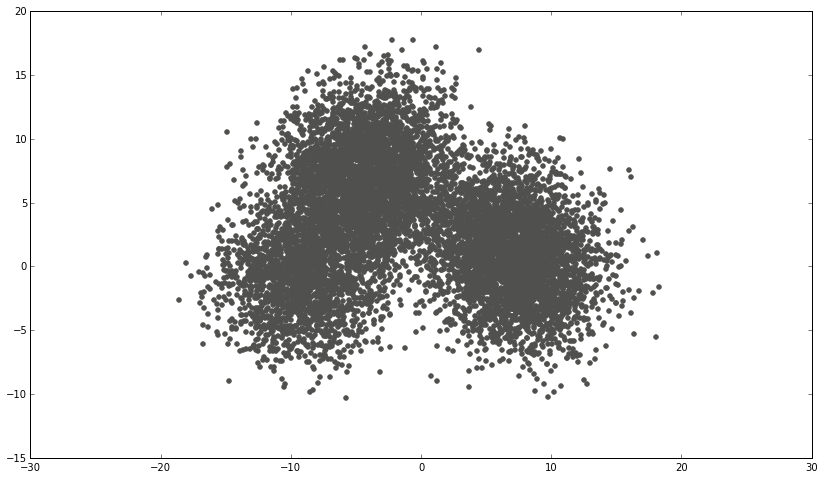

In [104]:
# Make some data
np.random.seed(46)
X, Y = make_blobs(n_samples=10000, n_features=2, centers=5, cluster_std=3)
plt.scatter(X[:,0], X[:, 1], s=20)

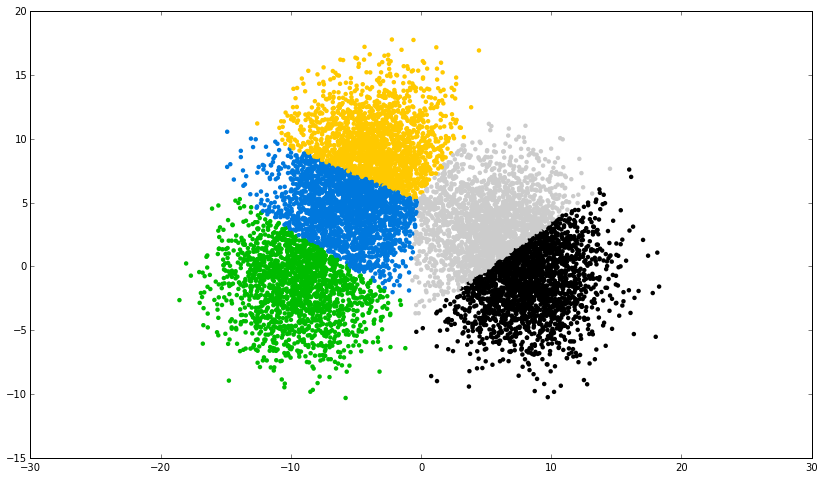

In [99]:
# KMeans
model = KMeans(5)
model.fit(X)
clusters = model.predict(X)
plt.scatter(X[:,0], X[:, 1], c=clusters, cmap=cm.nipy_spectral, linewidth=0, s=20)

In [132]:
def Decision_Surface(X, target, model, surface=True, cell_size=.01, points=True):
    # Get bounds
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, cell_size), np.arange(y_min, y_max, cell_size))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    
    # Add interactions
    for i in range(X.shape[1]):
        if i <= 1:
            continue
        
        meshed_data = np.c_[meshed_data, np.power(xx.ravel(), i)]

    Z = model.predict(meshed_data).reshape(xx.shape)
    
    # Plot mesh and data
    plt.title("humor and number_pets")
    plt.xlabel("humor")
    plt.ylabel("number_pets")
    if surface and model != None:
        cs = plt.contourf(xx, yy, Z, color=colorizer(model.predict(meshed_data)))
    if points:
        plt.scatter(X[:, 0], X[:, 1], color=colorizer(Y), linewidth=0, s=20)

In [125]:
def colorizer(Y):
    pal = ["#50514f", "#f25f5c", "#ffe066", "#247ba0", "#70c1b3"]
    colors = np.array(Y, dtype="object")

    for i, color in enumerate(np.unique(Y)):
        colors[colors == color] = pal[i]

    return list(colors)

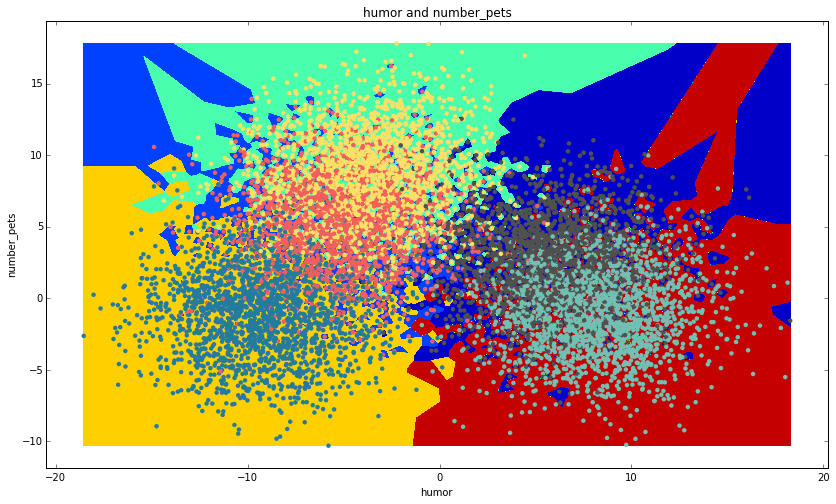

In [133]:
# KNN
model = KNeighborsClassifier(1)
model.fit(X, Y)
model.predict(X)
Decision_Surface(X, Y, model)

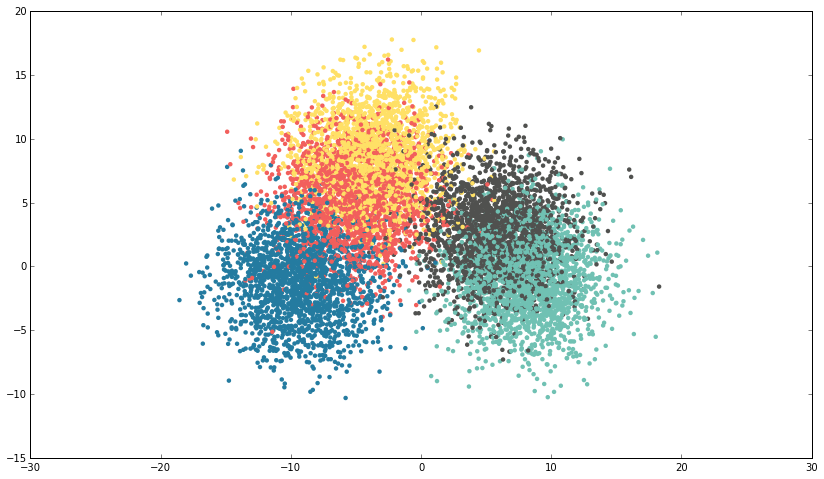

In [126]:
# Truth
plt.scatter(X[:,0], X[:, 1], color=list(colorizer(Y)), linewidth=0, s=20)

### Text as features
How can we turn the large amount of text for each record into useful features?


#### Binary representation
One way is to create a matrix that uses each word as a feature and keeps track of whether or not a word appears in a document/record. You can do this in sklearn with a `CountVectorizer()` and setting `binary` to `true`. The process is very similar to how you fit a model: you will fit a `CounterVectorizer()`. This will figure out what words exist in your data.

In [ ]:
binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(X_train)

Let's look at the vocabulary the `CountVectorizer()` learned.

In [ ]:
binary_vectorizer.vocabulary_.keys()[0:10]

Now that we know what words are in the data, we can transform our blobs of text into a clean matrix. Simply `.transform()` the raw data using our fitted `CountVectorizer()`. You will do this for the training and test data. What do you think happens if there are new words in the test data that were not seen in the training data?

In [ ]:
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

We can take a look at our new `X_test_counts`.

In [ ]:
X_test_binary

Sparse matrix? Where is our data?

If you look at the output above, you will see that it is being stored in a *sparse* matrix (as opposed to the typical dense matrix) that is ~2k rows long and ~70k columns. The rows here are records in the original data and the columns are words. Given the shape, this means there are ~140m cells that should have values. However, from the above, we can see that only ~220k cells (~0.15%) of the cells have values! Why is this?

To save space, sklearn uses a sparse matrix. This means that only values that are not zero are stored! This saves a ton of space! This also means that visualizing the data is a little trickier. Let's look at a very small chunk.

In [ ]:
X_test_binary[0:20, 0:20].todense()

#### Applying a model
Now that we have a ton of features (since we have a ton of words!) let's try using a logistic regression model to predict spam/ham.

In [ ]:
model = LogisticRegression()
model.fit(X_train_binary, Y_train)

print "Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_binary), Y_test)

Is this any good? What do we care about in this case? Let's take a look at our ROC measure in more detail by looking at the actual ROC curve.

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Binary")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

#### Counts instead of binary
Instead of using a 0 or 1 to represent the occurence of a word, we can use the actual counts. We do this the same way as before, but now we leave `binary` set to `false` (the default value).

In [ ]:
# Fit a counter
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_counts, Y_train)

print "Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_counts), Y_test)

We can also take a look at the ROC curve.

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_counts)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Counts")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

#### Tf-idf
Another popular technique when dealing with text is to use the term frequency - inverse document frequency (tf-idf) measure.

In [ ]:
# Fit a counter
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform to a counter
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

print "Area under the ROC curve on the test data = %.3f" % metrics.roc_auc_score(model.predict(X_test_counts), Y_test)

Once again, we can look at the ROC curve.

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])
tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Tfidf")
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

The `CountVectorizer()` and `TfidfVectorizer()` functions have many options. You can restrict the words you would like in the vocabulary. You can add n-grams. You can use stop word lists. Which options you should use generally depend on the type of data you are dealing with. We can discuss and try some of them now.

Now that we have a few different feature sets and models, let's look at all of our ROC curves.

In [ ]:
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()
plt.xlim([0, .07])
plt.ylim([.98, 1])
plt.show()

#### *A note on cross validation*
We didn't use cross validation here, but it is definitely possible. The code is a little messier, so we will leave this to a Forum discussion.

### Naive Bayes
So far we have been exposed to tree classifiers and logistic regression in class. We have also seen SVMs in the homwork. A popular modeling technique (especially in text classification) is the is the (Bernoulli) naive Bayes classifier.

Using this model in sklearn is just as easy as all the other models.

In [ ]:
model = BernoulliNB()
model.fit(X_train_tfidf, Y_train)

In [ ]:
print "AUC on the count data = %.3f" % metrics.roc_auc_score(model.predict(X_test_tfidf), Y_test)

The past few weeks we have seen that many of the models we are using have different parameters that can be tweaked. In naive Bayes, the parameter that is typically tuned is the Laplace smoothing value `alpha`. We won't discuss this in class, but will post a discussion on the NYU Classes Forum.  Also, there is another version of naive Bayes (not discussed in the book) called multinomial naive Bayes, which can handle count features and not just binary features.  We will give an additional reading covering that (in the Forum as well).  